In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import torch
from torch.utils.data import Dataset, DataLoader

from tqdm import tqdm
import os
import sys
import re

# customized packages
import dataset
import utils
from mlp import projector
from metricpref_learner import MetricPrefLearner

%load_ext autoreload
%autoreload 2

/home/daiwei/miniconda3/envs/rlhf/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
########### color dataset ################
N = 48
color_dataset = dataset.Dataset(dataset_type='Color',color_path='./CPdata.mat', N=N)
color_data = color_dataset.getAllData()
items, observations, true_y, true_M, true_u = color_data['X'], color_data['S'], color_data['Y'], color_data['M'], color_data['U']
# automatically extract 300 samples from each user
obs_train, obs_test, Y_train, Y_test = color_dataset.getTrainTestSplit(train_size=48*300)   

In [8]:
37*36/2

666.0

In [15]:
########### hyperparameters ################
epochs = 2000
bs = 32
lr = 1e-4
momentum = 0.9
weight_decay = 0.005
dim = 3
device = 'mps'

# TODO: design different weight decay rate for us and L
weight_decay_us = 0
weight_decay_net = 0

In [16]:
############ define dataloader ################
class CustomDataset(Dataset):   # written by the gpt-4 :)
    def __init__(self, data_list):
        self.data_list = data_list

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        return self.data_list[idx]

train_dataset = CustomDataset(list(zip(obs_train, Y_train)))
train_dataloader = DataLoader(train_dataset, batch_size=bs, shuffle=True)

test_dataset = CustomDataset(list(zip(obs_test, Y_test)))
test_dataloader = DataLoader(test_dataset, batch_size=bs, shuffle=True)

In [17]:
############ initialize the model and the learner################
net = projector(feature_dim=dim, num_layer=1, num_class=dim, bias_ind=False)
learner = MetricPrefLearner(dim_feature=dim, num_users=N, items=items)
learner.assignModel(net)

us_params = []
net_params = []
for name, param in learner.named_parameters():
    if 'us' in name:
        us_params.append(param)
    else:
        net_params.append(param)

In [18]:
############ define loss and optimizer ################
def hinge_loss(outputs, targets):   # written by the gpt-4 :)
    hinge_loss_value = 1 - targets * outputs
    hinge_loss_value = torch.clamp(hinge_loss_value, min=0)
    return hinge_loss_value.mean()

def logistic(z):
    return 1 / (1 + torch.exp(-z))

def nll_logistic(predictions, targets):
    # Ensure targets are -1 or 1
    assert torch.all((targets == -1) | (targets == 1))
    
    probabilities = logistic(targets * predictions)
    # print(probabilities)
    nll = -torch.sum(torch.log(probabilities))
    # print(nll)
    return nll

weight_decay_dic = [
    {'params': us_params, 'weight_decay': weight_decay_us},
    {'params': net_params, 'weight_decay': weight_decay_net}
]


loss_fn = hinge_loss
optimizer = torch.optim.Adam(weight_decay_dic, lr=1e-3, betas=(0.9, 0.999), eps=1e-8)
# optimizer = torch.optim.SGD(learner.parameters(),lr=lr,momentum=momentum,weight_decay=weight_decay)

In [19]:
def train(learner,optimizer,loss_fn,train_loader,test_loader,epochs,relative_error_ind=True):
    train_stats = {
        'train_loss_per_batch_record': [],
        'train_accu_record': [],
        'test_loss_per_batch_record': [],
        'test_accu_record': [],
        'relative_metric_error_record': [],
        'relative_ideal_point_error_record': [],
    }

    tqdmr = tqdm(range(epochs))
    for ep in tqdmr:
        for x,y in train_loader:
            # x[0] = x[0].to(device)
            # x[1][0] = x[1][0].to(device)
            # x[1][1] = x[1][1].to(device)
            # y = y.to(device)
            optimizer.zero_grad()
            pred_delta = learner(x)
            acc_batch = torch.sum((pred_delta * y)>0)
            if relative_error_ind:
                # calculate the relative_metric_error
                L = net.layers.weight
                relative_metric_error = torch.norm(L.T @ L - torch.tensor(true_M)) / torch.norm(torch.tensor(true_M))
                train_stats['relative_metric_error_record'].append(relative_metric_error.item())
                # calculate the relative_ideal_point_error
                relative_ideal_point_error = (torch.norm(torch.tensor(true_u)-learner.us) / torch.norm(torch.tensor(true_u))).item()
                train_stats['relative_ideal_point_error_record'].append(relative_ideal_point_error)
            loss = loss_fn(pred_delta,y)
            train_stats['train_loss_per_batch_record'].append(loss.item())
            train_stats['train_accu_record'].append(acc_batch/bs)
            loss.backward()
            optimizer.step()
        val_stat = val(learner,loss_fn,test_loader)
        train_stats['test_loss_per_batch_record'].extend(val_stat['test_loss_per_batch'])
        train_stats['test_accu_record'].append(val_stat['test_accu'])
        tqdmr.set_postfix({'test_accu': val_stat['test_accu']})
    return train_stats

def val(learner,loss_fn,test_loader):
    total_val_samples = len(test_loader.dataset)
    val_stat = {
        'test_correct': 0,
        'test_loss_per_batch': [],
        'test_accu': 0
    }
    with torch.no_grad():
        for x,y in test_loader:
            # x[0] = x[0].to(device)
            # x[1][0] = x[1][0].to(device)
            # x[1][1] = x[1][1].to(device)
            # y = y.to(device)
            pred_delta = learner(x)
            acc_batch = torch.sum((pred_delta * y)>0)
            loss = loss_fn(pred_delta,y)

            val_stat['test_correct'] += acc_batch.item()
            val_stat['test_loss_per_batch'].append(loss.item())
    
    val_stat['test_accu'] = val_stat['test_correct'] / total_val_samples

    return val_stat


In [20]:
train_stats = train(learner, optimizer, loss_fn, train_dataloader, test_dataloader, epochs, relative_error_ind=False)

100%|██████████| 2000/2000 [11:45<00:00,  2.83it/s, test_accu=0.621]


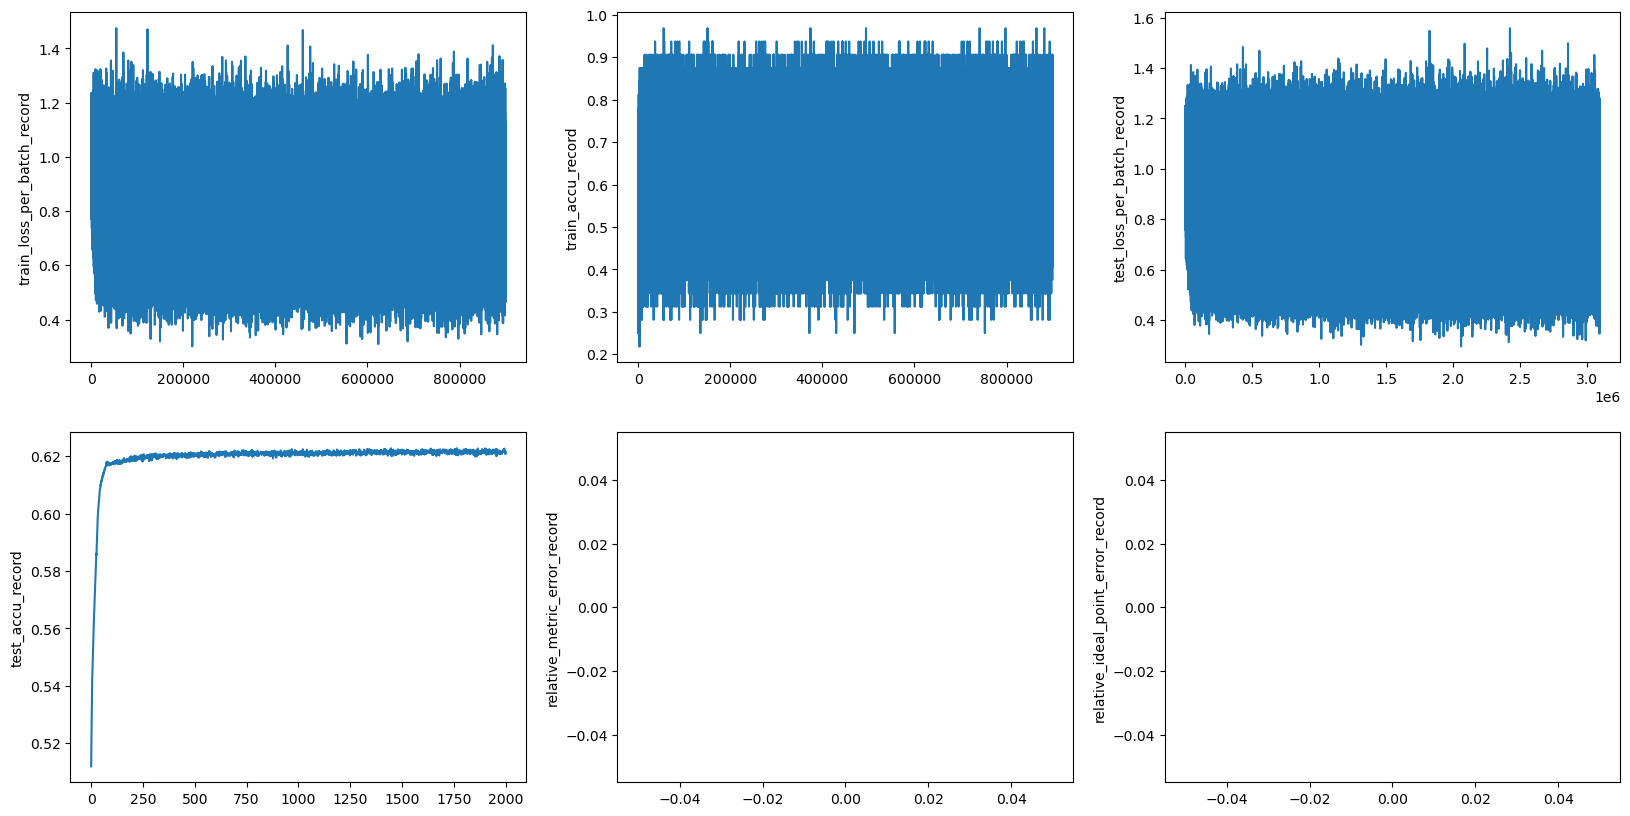

In [21]:
fig,ax = plt.subplots(2,3,figsize=(20,10))
ax_flatten = ax.flatten()
for idx,key in enumerate(train_stats):
    ax_flatten[idx].plot(train_stats[key])
    ax_flatten[idx].set_ylabel(key)

# All in One

In [2]:
def train(learner,optimizer,loss_fn,train_loader,test_loader,epochs,relative_error_ind=True):
    train_stats = {
        'train_loss_per_batch_record': [],
        'train_accu_record': [],
        'test_loss_per_batch_record': [],
        'test_accu_record': [],
        'relative_metric_error_record': [],
        'relative_ideal_point_error_record': [],
    }

    tqdmr = tqdm(range(epochs))
    for ep in tqdmr:
        for x,y in train_loader:
            # x[0] = x[0].to(device)
            # x[1][0] = x[1][0].to(device)
            # x[1][1] = x[1][1].to(device)
            # y = y.to(device)
            optimizer.zero_grad()
            pred_delta = learner(x)
            acc_batch = torch.sum((pred_delta * y)>0)
            if relative_error_ind:
                # calculate the relative_metric_error
                L = net.layers.weight
                relative_metric_error = torch.norm(L.T @ L - torch.tensor(true_M)) / torch.norm(torch.tensor(true_M))
                train_stats['relative_metric_error_record'].append(relative_metric_error.item())
                # calculate the relative_ideal_point_error
                relative_ideal_point_error = (torch.norm(torch.tensor(true_u)-learner.us) / torch.norm(torch.tensor(true_u))).item()
                train_stats['relative_ideal_point_error_record'].append(relative_ideal_point_error)
            loss = loss_fn(pred_delta,y)
            train_stats['train_loss_per_batch_record'].append(loss.item())
            train_stats['train_accu_record'].append(acc_batch/len(y))
            loss.backward()
            optimizer.step()
        val_stat = val(learner,loss_fn,test_loader)
        train_stats['test_loss_per_batch_record'].extend(val_stat['test_loss_per_batch'])
        train_stats['test_accu_record'].append(val_stat['test_accu'])
        tqdmr.set_postfix({'test_accu': val_stat['test_accu']})
    return train_stats

def val(learner,loss_fn,test_loader):
    total_val_samples = len(test_loader.dataset)
    val_stat = {
        'test_correct': 0,
        'test_loss_per_batch': [],
        'test_accu': 0
    }
    with torch.no_grad():
        for x,y in test_loader:
            # x[0] = x[0].to(device)
            # x[1][0] = x[1][0].to(device)
            # x[1][1] = x[1][1].to(device)
            # y = y.to(device)
            pred_delta = learner(x)
            acc_batch = torch.sum((pred_delta * y)>0)
            loss = loss_fn(pred_delta,y)

            val_stat['test_correct'] += acc_batch.item()
            val_stat['test_loss_per_batch'].append(loss.item())
    
    val_stat['test_accu'] = val_stat['test_correct'] / total_val_samples

    return val_stat

class CustomDataset(Dataset):   # written by the gpt-4 :)
    def __init__(self, data_list):
        self.data_list = data_list

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        return self.data_list[idx]
    
def hinge_loss(outputs, targets):   # written by the gpt-4 :)
    hinge_loss_value = 1 - targets * outputs
    hinge_loss_value = torch.clamp(hinge_loss_value, min=0)
    return hinge_loss_value.mean()

def logistic(z):
    return 1 / (1 + torch.exp(-z))

def nll_logistic(predictions, targets):
    # Ensure targets are -1 or 1
    assert torch.all((targets == -1) | (targets == 1))
    
    probabilities = logistic(targets * predictions)
    # print(probabilities)
    nll = -torch.sum(torch.log(probabilities))
    # print(nll)
    return nll

In [3]:
def train_main(args):
    ########### hyperparameters from args ################
    epochs = args['epochs']
    bs = args['bs']
    lr = args['lr']
    feature_dim = args['feature_dim']
    num_users = args['num_users']  # fixed at 48 for color dataset 
    num_pairs_per_user = args['num_pairs_per_user']
    # design different weight decay rate for us and L
    weight_decay_us = args['weight_decay_us']
    weight_decay_net = args['weight_decay_net']

    # ########### hyperparameters ################
    # epochs = 2000
    # bs = 32
    # lr = 1e-3
    # momentum = 0.9
    # feature_dim = 3
    # device = 'mps'
    # num_users = 48  # fixed at 48 for color dataset 
    # num_pairs_per_user = 300

    # # design different weight decay rate for us and L
    # weight_decay_us = 0
    # weight_decay_net = 0

    ########### color dataset ################
    color_dataset = dataset.Dataset(dataset_type='Color',color_path='./CPdata.mat', N=num_users)
    color_data = color_dataset.getAllData()
    items, observations, true_y, true_M, true_u = color_data['X'], color_data['S'], color_data['Y'], color_data['M'], color_data['U']
    # automatically extract 300 samples from each user
    obs_train, obs_test, Y_train, Y_test = color_dataset.getTrainTestSplit(train_size=num_users*num_pairs_per_user)

    ############ define dataloader ################
    train_dataset = CustomDataset(list(zip(obs_train, Y_train)))
    train_dataloader = DataLoader(train_dataset, batch_size=bs, shuffle=True)

    test_dataset = CustomDataset(list(zip(obs_test, Y_test)))
    test_dataloader = DataLoader(test_dataset, batch_size=bs, shuffle=True)

    ############ initialize the model and the learner################
    net = projector(feature_dim=feature_dim, num_layer=1, num_class=feature_dim, bias_ind=False)
    learner = MetricPrefLearner(dim_feature=feature_dim, num_users=num_users, items=items)
    learner.assignModel(net)
    us_params = []
    net_params = []
    for name, param in learner.named_parameters():
        if 'us' in name:
            us_params.append(param)
        else:
            net_params.append(param)

    ############ define loss and optimizer ################
    weight_decay_dic = [
        {'params': us_params, 'weight_decay': weight_decay_us},
        {'params': net_params, 'weight_decay': weight_decay_net}
    ]

    loss_fn = hinge_loss
    optimizer = torch.optim.Adam(weight_decay_dic, lr=lr, betas=(0.9, 0.999), eps=1e-8)
    # optimizer = torch.optim.SGD(learner.parameters(),lr=lr,momentum=momentum,weight_decay=weight_decay)
    train_stats = train(learner, optimizer, loss_fn, train_dataloader, test_dataloader, epochs, relative_error_ind=False)
    
    return train_stats, learner

In [4]:
args = {
    'epochs': 2000,
    'bs': 32,
    'lr': 1e-3,
    'feature_dim': 3,
    'num_users': 48,
    'num_pairs_per_user': 300,
    'weight_decay_us': 0,
    'weight_decay_net': 0,
}

train_stats = train_main(args)

 63%|██████▎   | 1255/2000 [06:52<04:24,  2.82it/s, test_accu=0.604]

In [ ]:
fig,ax = plt.subplots(2,3,figsize=(20,10))
ax_flatten = ax.flatten()
for idx,key in enumerate(train_stats):
    ax_flatten[idx].plot(train_stats[key])
    ax_flatten[idx].set_ylabel(key)

In [ ]:
import itertools

lr_list = [1e-2,5e-3,1e-3,5e-4,1e-4]
bs_list = [16,32,64,128]
weight_decay_us_list = [1e-3,5e-4,1e-4,0]
weight_decay_net_list = [1e-3,5e-4,1e-4,0]
param_combinations = list(itertools.product(lr_list, bs_list, weight_decay_us_list, weight_decay_net_list))

def _per_run(lr, bs, weight_decay_us, weight_decay_net):
    args = {
        'epochs': 2000,
        'bs': bs,
        'lr': lr,
        'feature_dim': 3,
        'num_users': 48,
        'num_pairs_per_user': 300,
        'weight_decay_us': weight_decay_us,
        'weight_decay_net': weight_decay_net,
    }
    print('current params:', args)
    train_stats, learner = train_main(args)
    torch.save({'args':args, 'train_stats': train_stats, 'learner': learner}, f'grid_search_lr{lr}_bs{bs}_wdu{weight_decay_us}_wdn{weight_decay_net}.pt')

for lr, bs, weight_decay_us, weight_decay_net in param_combinations:
    args = {
        'epochs': 2000,
        'bs': bs,
        'lr': lr,
        'feature_dim': 3,
        'num_users': 48,
        'num_pairs_per_user': 300,
        'weight_decay_us': weight_decay_us,
        'weight_decay_net': weight_decay_net,
    }
    print('current params:', args)
    train_stats, learner = train_main(args)
    torch.save({'args':args, 'train_stats': train_stats, 'learner': learner}, f'grid_search_lr{lr}_bs{bs}_wdu{weight_decay_us}_wdn{weight_decay_net}.pt')